In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
ents = [0.0, 0.01, 0.05, 0.1, 0.4, 0.8]
clips = [0.005, 0.02, 0.08, 0.2, 0.5, 0.8, 1e6]

In [3]:
def plot_svd(env_name, ents, clips, y_maxr=None, tick=1, k=10):
    with open(f"./shared/feature_matrix/{env_name}_actions.npy", 'rb') as f:
        actions = np.load(f)
    with open(f"./shared/feature_matrix/{env_name}_features.npy", 'rb') as f:
        features = np.load(f)
        
    assert len(actions.shape) == 4  # (n_seeds, n_ent, n_clip, batch_size)
    assert len(features.shape) == 5  # (n_seeds, n_ent, n_clip, batch_size, feature_dim)
    print("Actions shape:", actions.shape)
    print("Features shape:", features.shape)

    sF = np.linalg.svd(features)[1]
    assert sF.shape[1:3] == (len(ents), len(clips))
    print("sF shape:", sF.shape)
    print("Max sF:", np.max(np.mean(sF, axis=0)))

    # Normalize
    sF /= np.max(sF, axis=-1, keepdims=True)
    
    sF = sF[..., :k]
    
    sF = np.mean(sF, axis=0)
    
    print("\nSingular values of feature matrix")
    plt.figure(figsize=(24, 15))
    indices = range(sF.shape[-1])
    for j in range(sF.shape[0]):
        ax = plt.subplot(2, 3, j+1)
        for k in range(sF.shape[1]):
            sns.lineplot(x=indices, y=sF[j, k, :], label=f"eps={clips[k] if clips[k]<1000 else None}")
        
        plt.xlabel("Index")
        plt.ylabel("Singular value")
        plt.ylim(top=y_maxr)
        ax.xaxis.set_major_locator(plticker.MultipleLocator(base=tick))
        plt.title(f"Ent. bonus={ents[j]}")
    plt.show()
        
#     return sF


def plot_features(env_name, ents, clips, seed=0, i=1, j=2):
    with open(f"./shared/feature_matrix/{env_name}_actions.npy", 'rb') as f:
        actions = np.load(f)
    with open(f"./shared/feature_matrix/{env_name}_features.npy", 'rb') as f:
        features = np.load(f)
        
    assert len(actions.shape) == 4  # (n_seeds, n_ent, n_clip, batch_size)
    assert len(features.shape) == 5  # (n_seeds, n_ent, n_clip, batch_size, feature_dim)
    print("Actions shape:", actions.shape)
    print("Features shape:", features.shape)

    actions = actions[seed]  # (n_ent, n_clip, batch_size)
    features = features[seed]  # (n_ent, n_clip, batch_size, feature_dim)

    actions = actions[i, j]
    features = features[i, j]
            
#     pca = PCA(n_components=50)
#     features = pca.fit_transform(features)
#     tsne = TSNE(n_components=2, n_iter=10000)
#     features = tsne.fit_transform(features)
    
    pca = PCA(n_components=2)
    features = pca.fit_transform(features) 

    print(features.shape)
    sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=actions)
    

def classify(env_name, ents, clips, seed=0, y_max=1.05, tick=0.1, algo="svc"):
    with open(f"./shared/feature_matrix/{env_name}_actions.npy", 'rb') as f:
        actions = np.load(f)
    with open(f"./shared/feature_matrix/{env_name}_features.npy", 'rb') as f:
        features = np.load(f)
        
    assert len(actions.shape) == 4  # (n_seeds, n_ent, n_clip, batch_size)
    assert len(features.shape) == 5  # (n_seeds, n_ent, n_clip, batch_size, feature_dim)
    print("Actions shape:", actions.shape)
    print("Features shape:", features.shape)

    actions = actions[seed]  # (n_ent, n_clip, batch_size)
    features = features[seed]  # (n_ent, n_clip, batch_size, feature_dim)

    if algo == "svc":
        print("\nLinear SVC accuracy")
    elif algo == "logreg":
        print("\nSoftmax accuracy")

    plt.figure(figsize=(24, 15))
    
    for j in range(features.shape[0]):
        ax = plt.subplot(2, 3, j+1)
        scores = []
        labels = []
        for k in range(features.shape[1]):
            if algo == "svc":
                model = LinearSVC(max_iter=1000000)
            elif algo == "logreg":
                model = LogisticRegression(multi_class="multinomial", max_iter=1000000)
            
            model.fit(features[j, k, :, :], actions[j, k, :])
            score = model.score(features[j, k, :, :], actions[j, k, :])
            scores.append(score)
            labels.append(f"eps={clips[k] if clips[k]<1000 else None}")
        
        sns.barplot(x=labels, y=scores)
        
        plt.ylabel("Accuracy")
        plt.ylim(top=y_max)
        ax.yaxis.set_major_locator(plticker.MultipleLocator(base=tick))
        plt.title(f"Ent. bonus={ents[j]}")
    plt.show()
    
#     return model

## 1. Acrobot

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)
(500, 2)


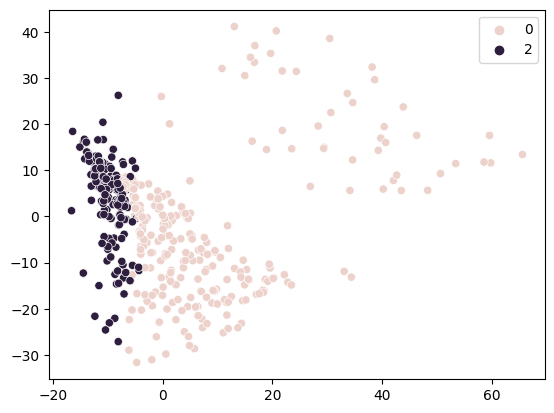

In [4]:
plot_features("Acrobot-v1", ents, clips)

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)

Softmax accuracy


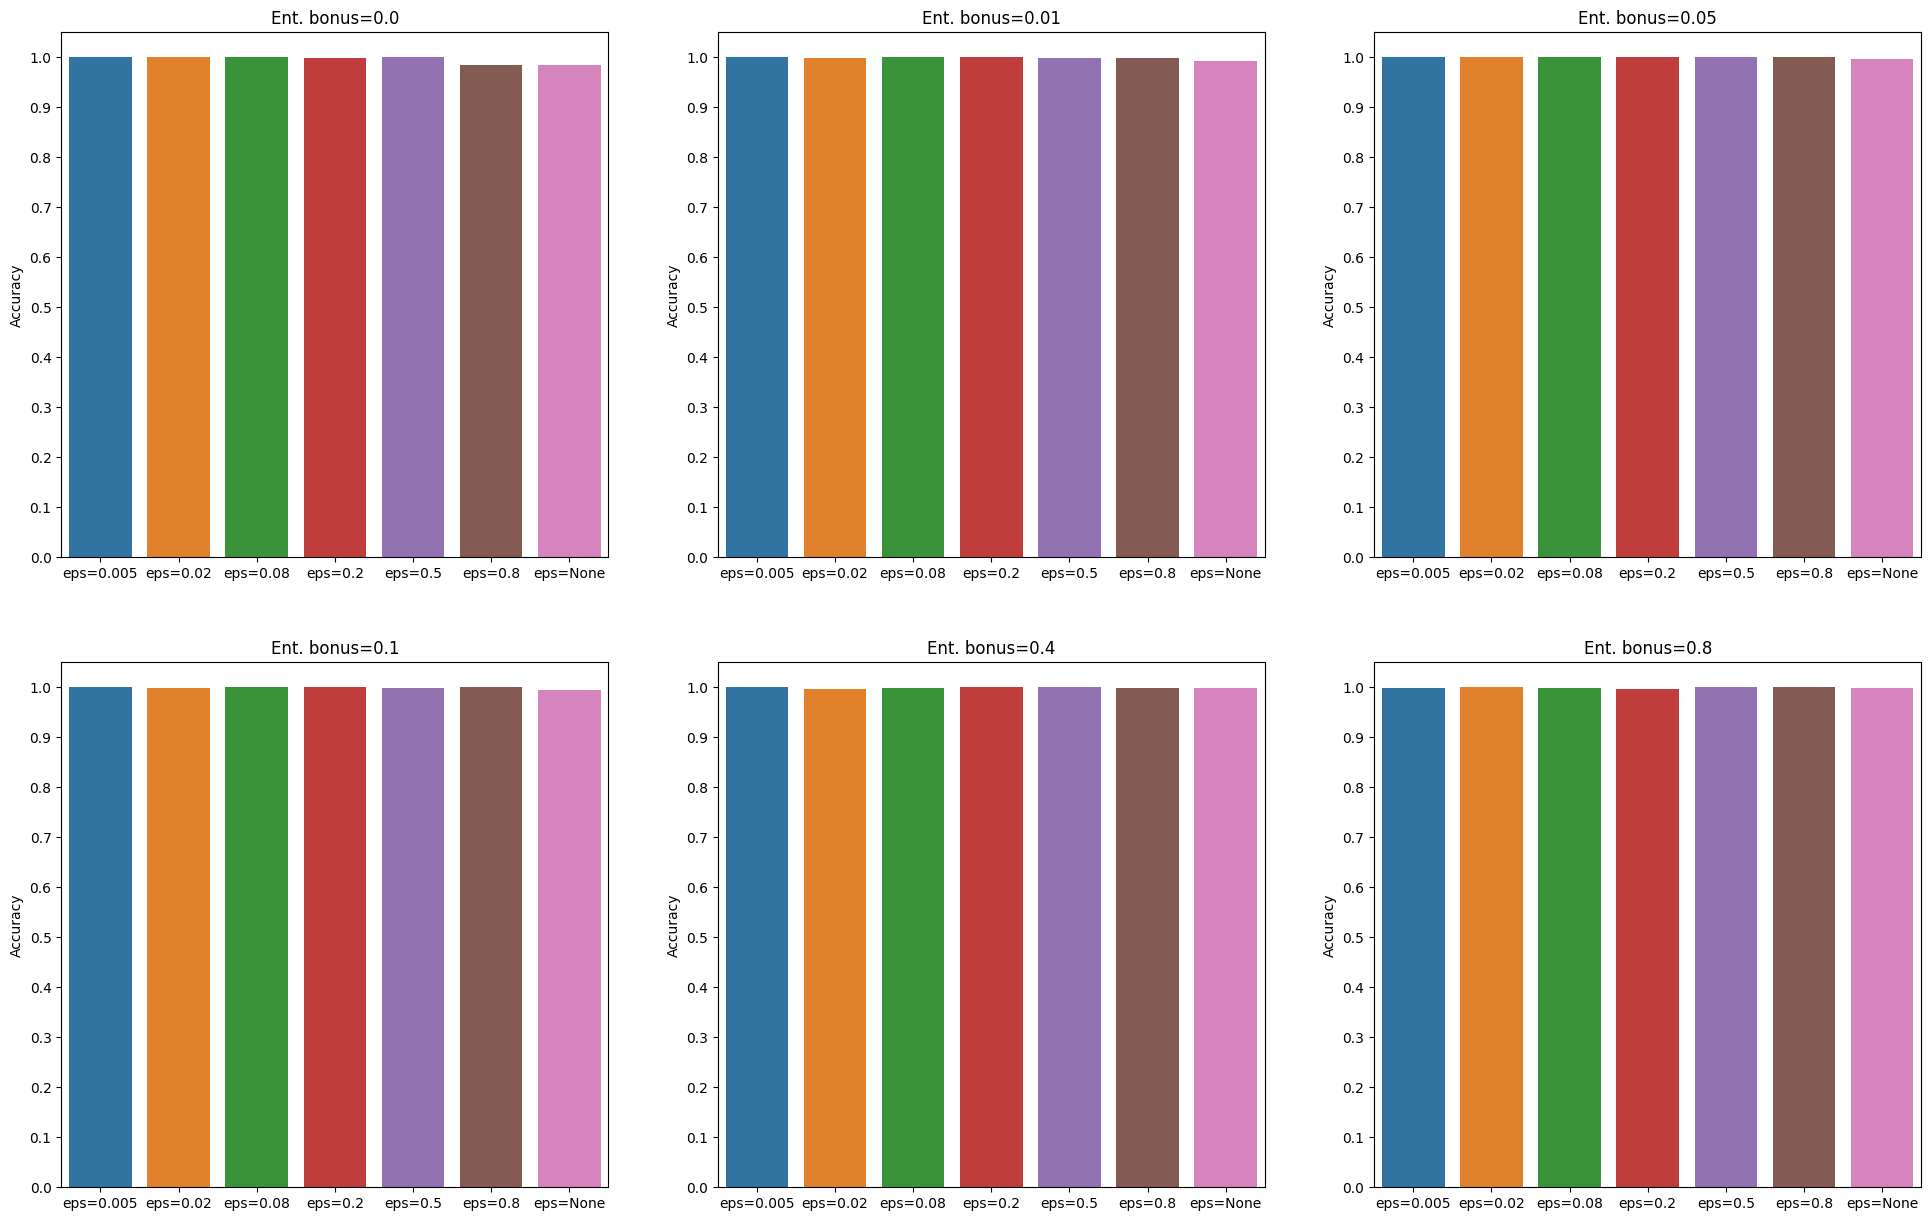

In [5]:
classify("Acrobot-v1", ents, clips, algo="logreg")

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)
sF shape: (8, 6, 7, 64)
Max sF: 1200.5831265909733

Singular values of feature matrix


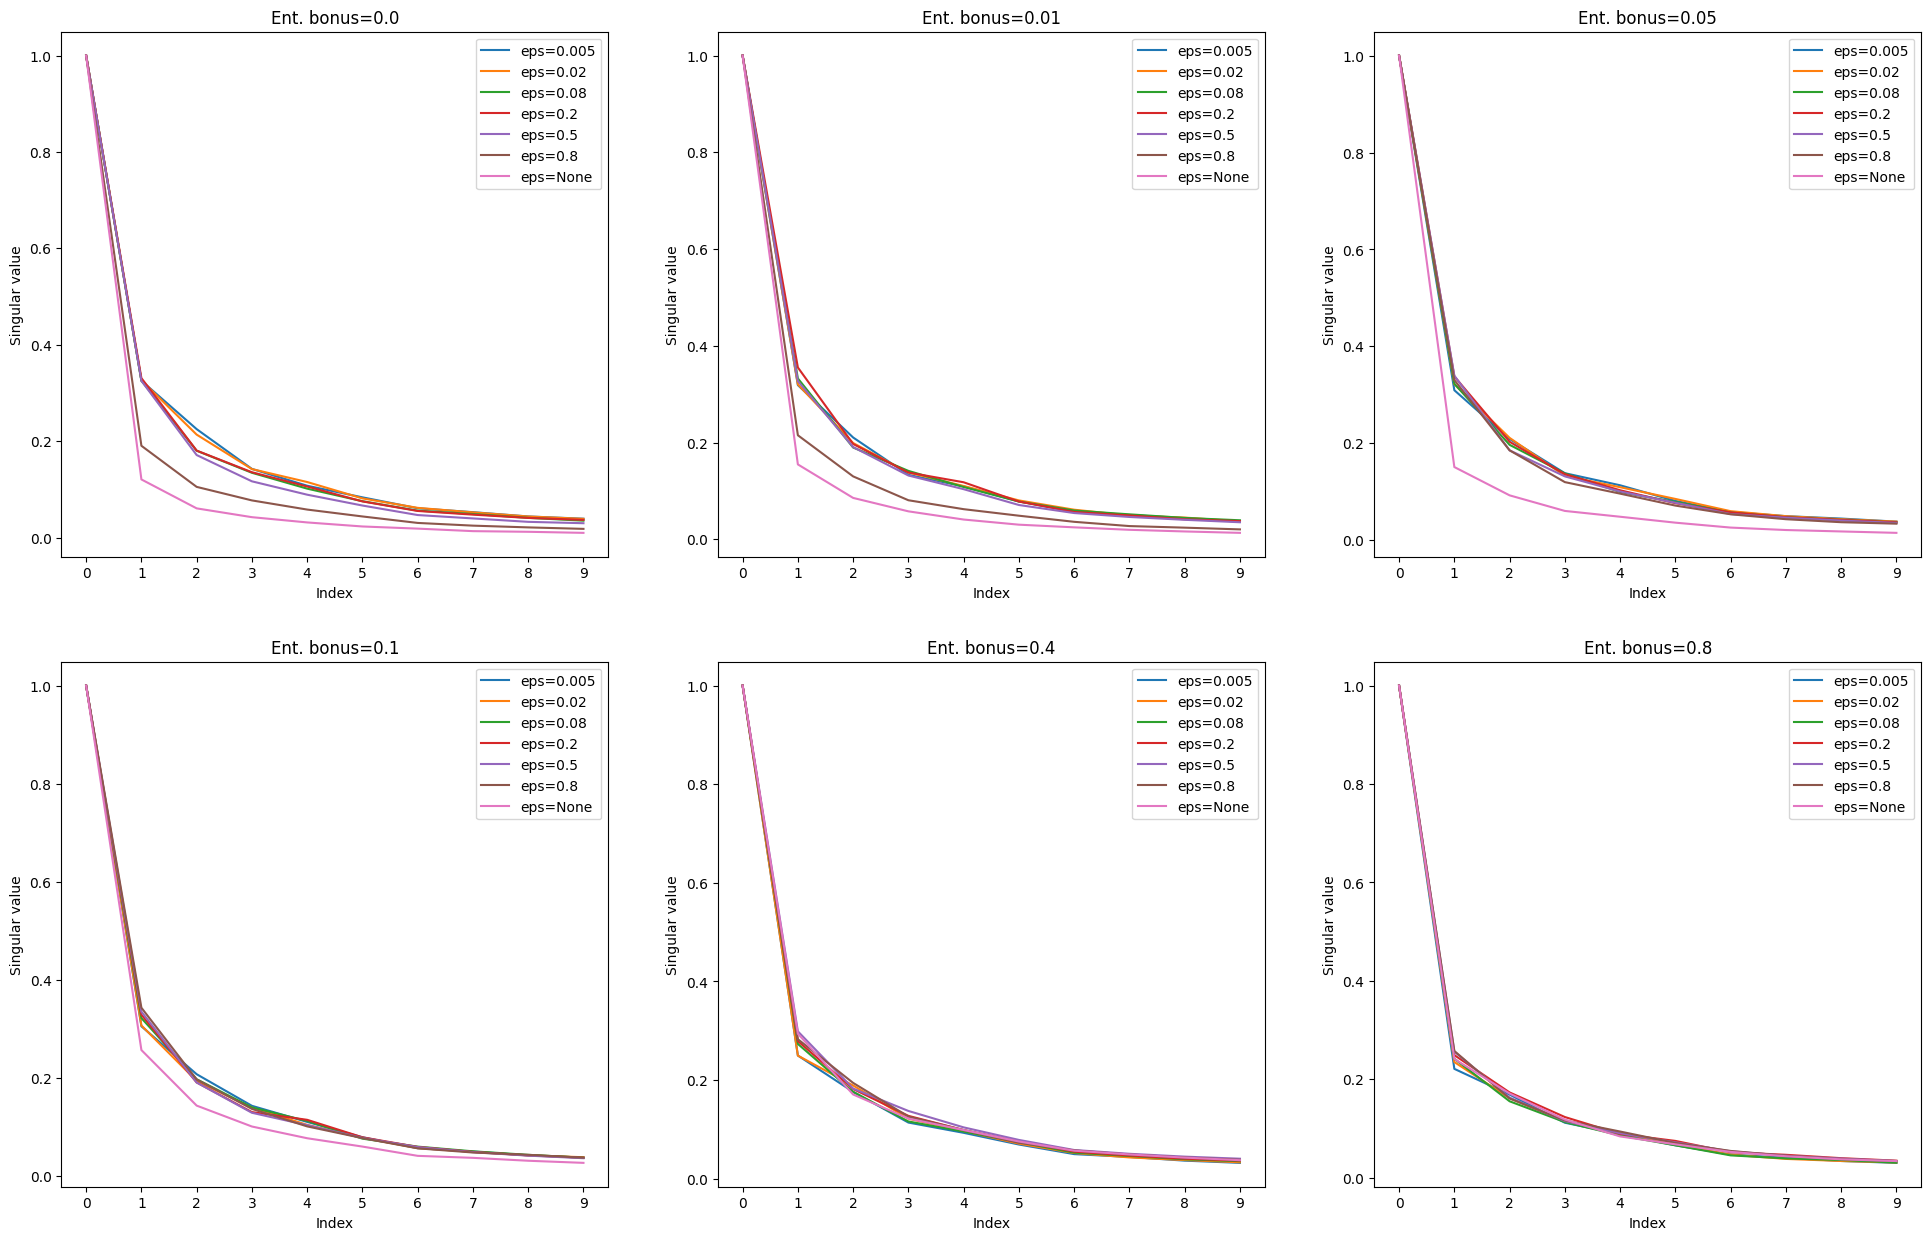

In [6]:
plot_svd("Acrobot-v1", ents, clips)

## 2. Asterix

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
(1000, 2)


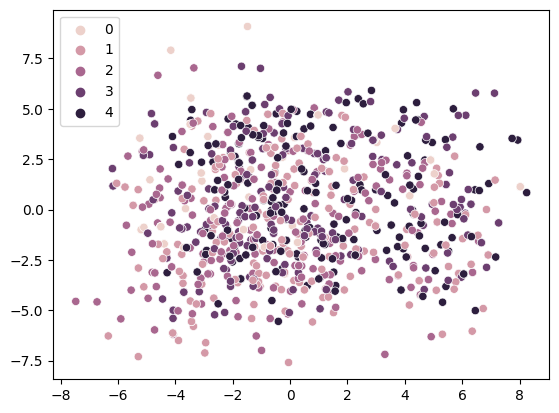

In [7]:
plot_features("Asterix-MinAtar", ents, clips)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)

Softmax accuracy


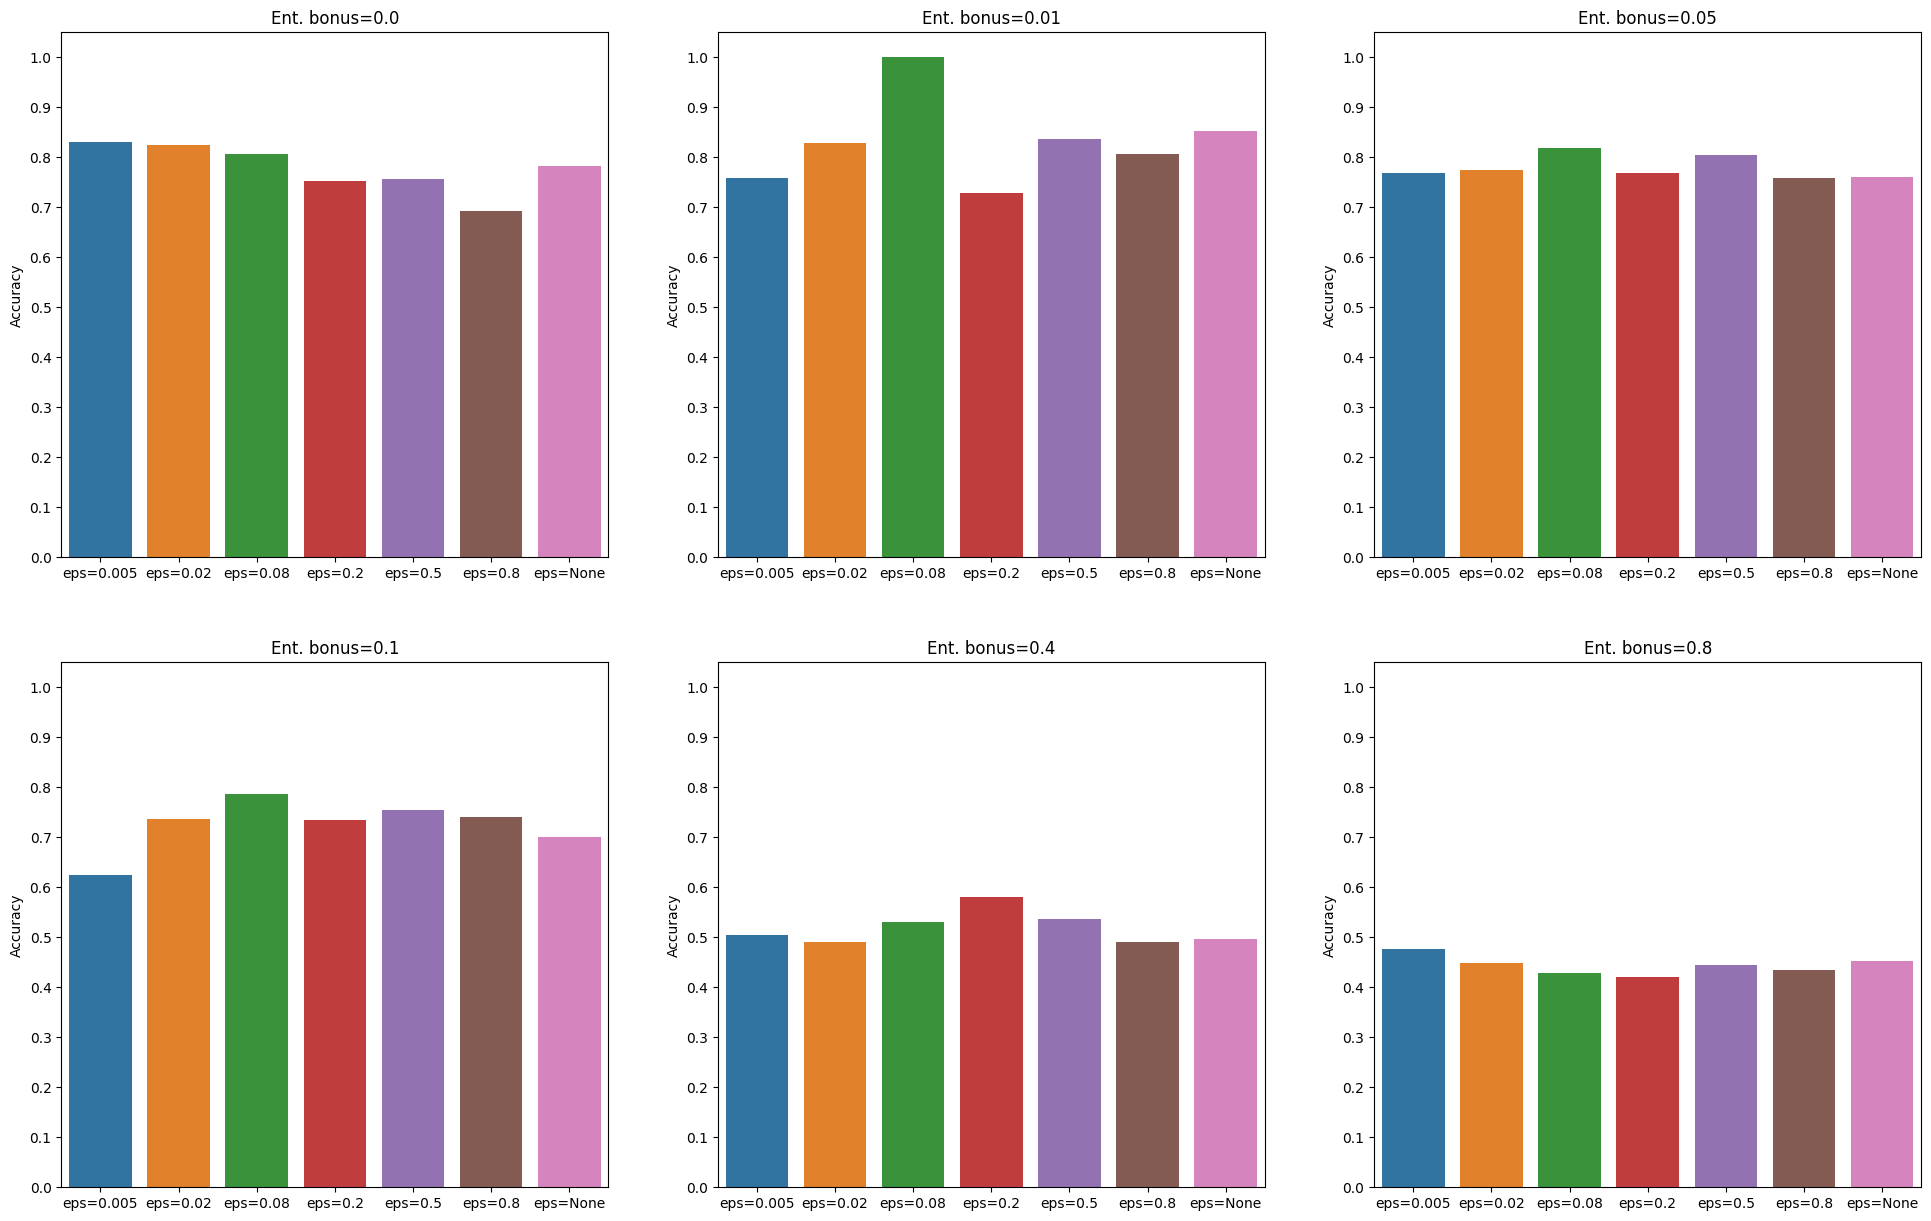

In [8]:
classify("Asterix-MinAtar", ents, clips, algo="logreg")

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
sF shape: (8, 6, 7, 256)
Max sF: 1202.3207

Singular values of feature matrix


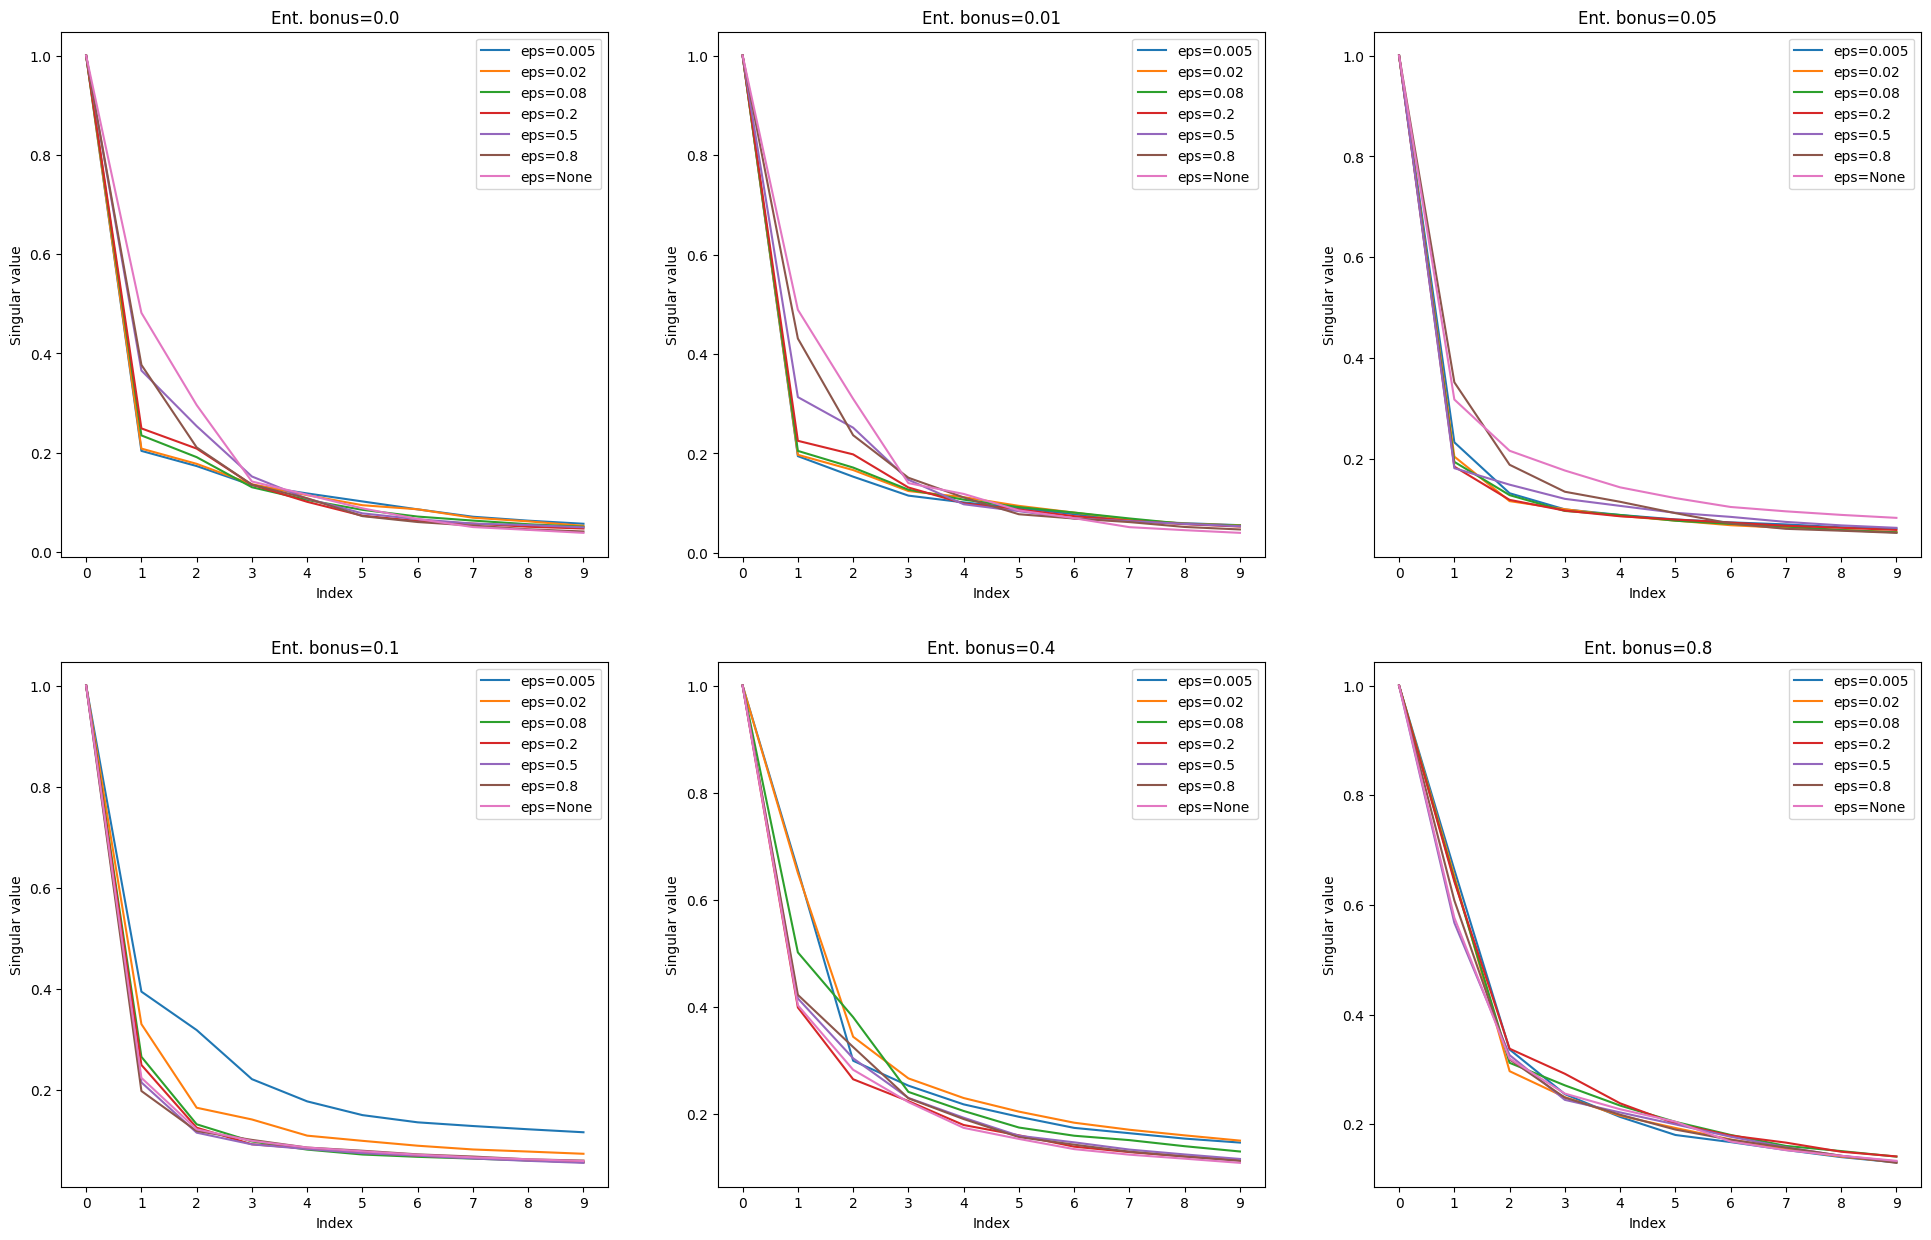

In [9]:
plot_svd("Asterix-MinAtar", ents, clips)

## 3. Breakout

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
(1000, 2)


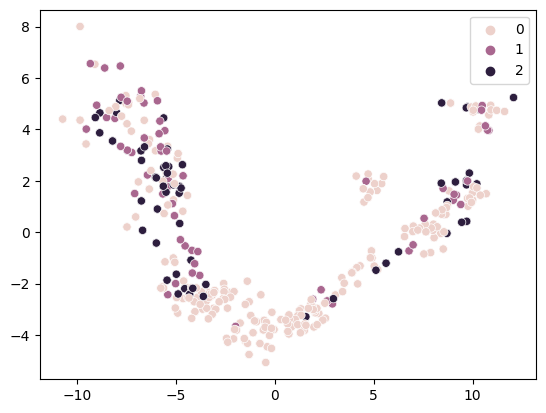

In [10]:
plot_features("Breakout-MinAtar", ents, clips)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)

Softmax accuracy


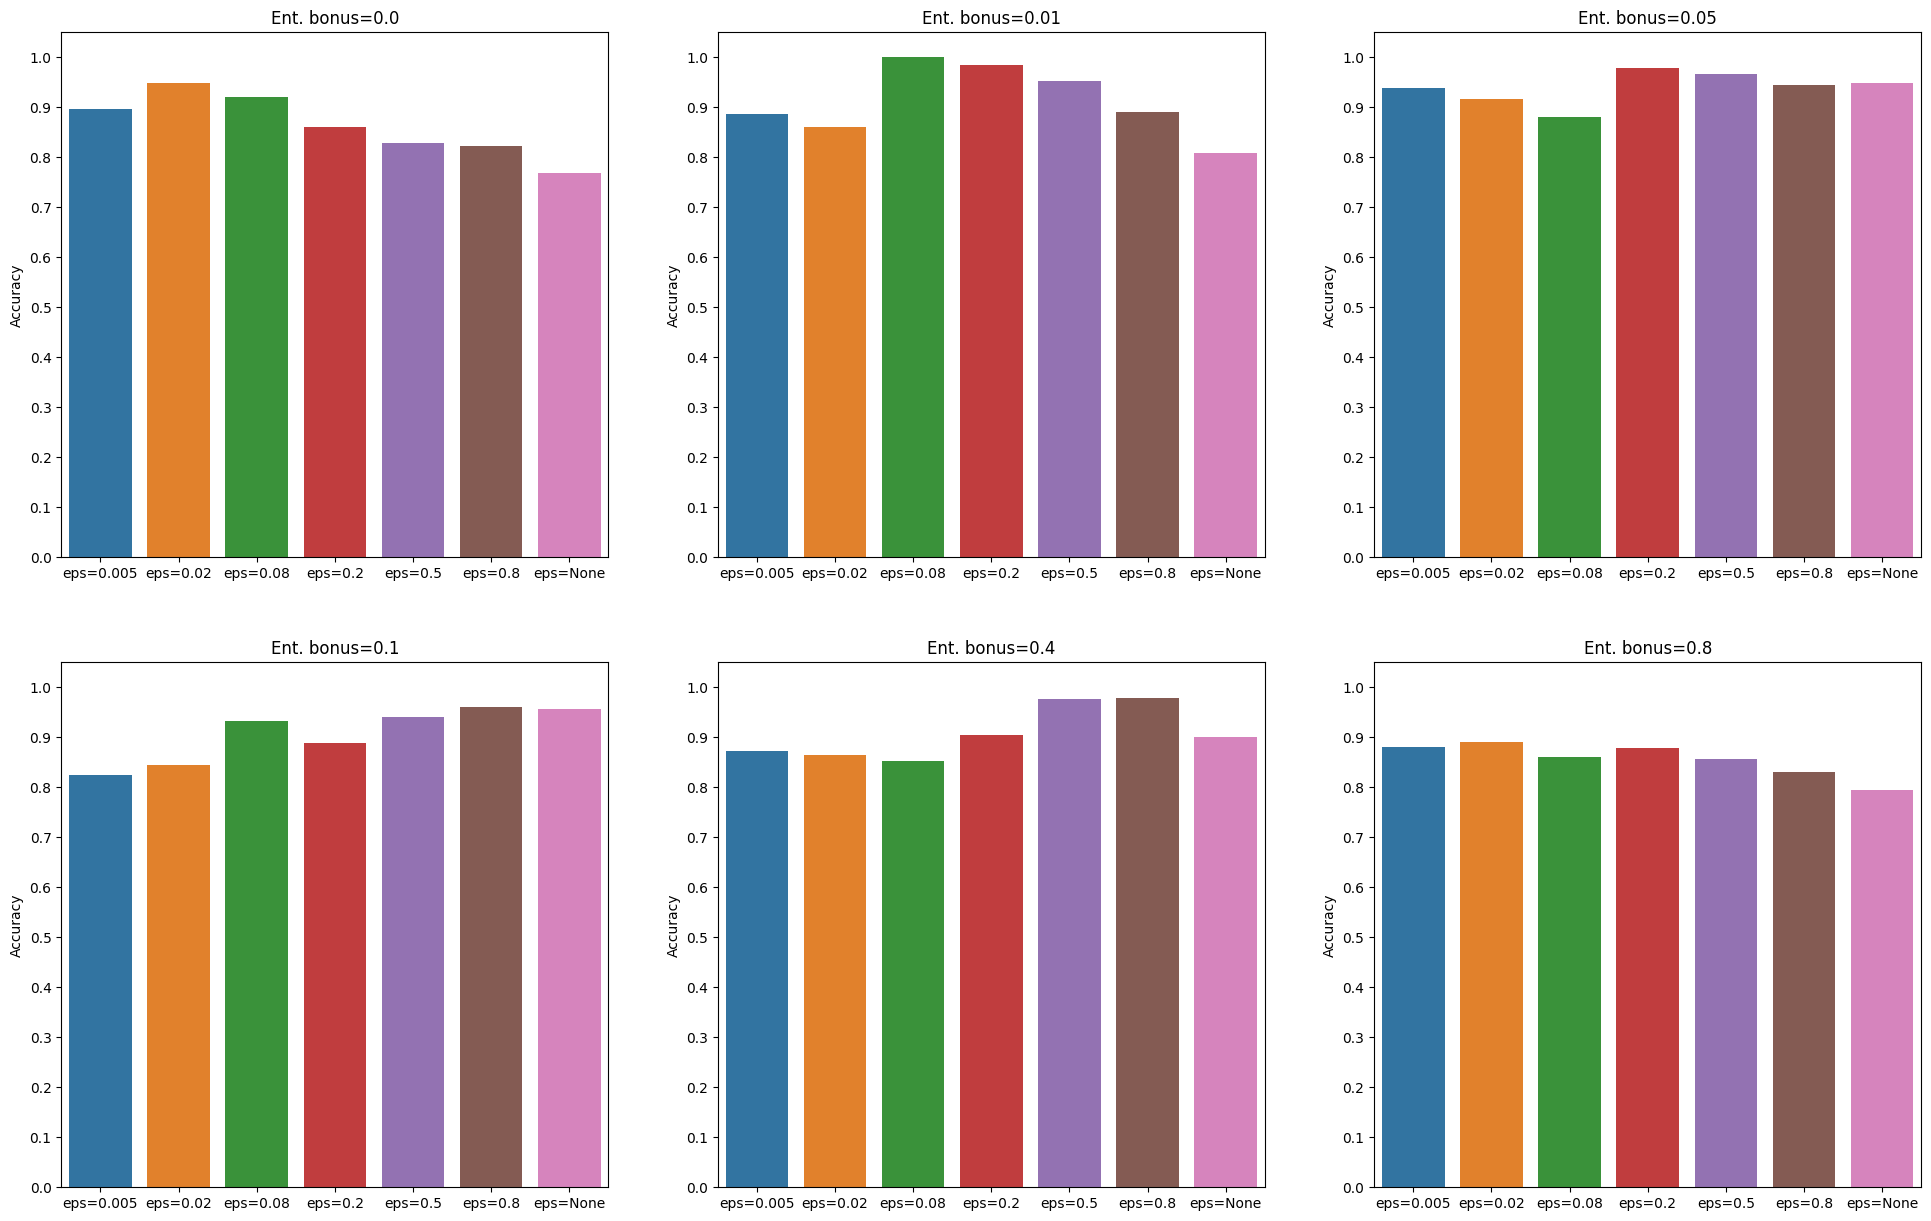

In [11]:
classify("Breakout-MinAtar", ents, clips, algo="logreg")

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
sF shape: (8, 6, 7, 256)
Max sF: 763.8169

Singular values of feature matrix


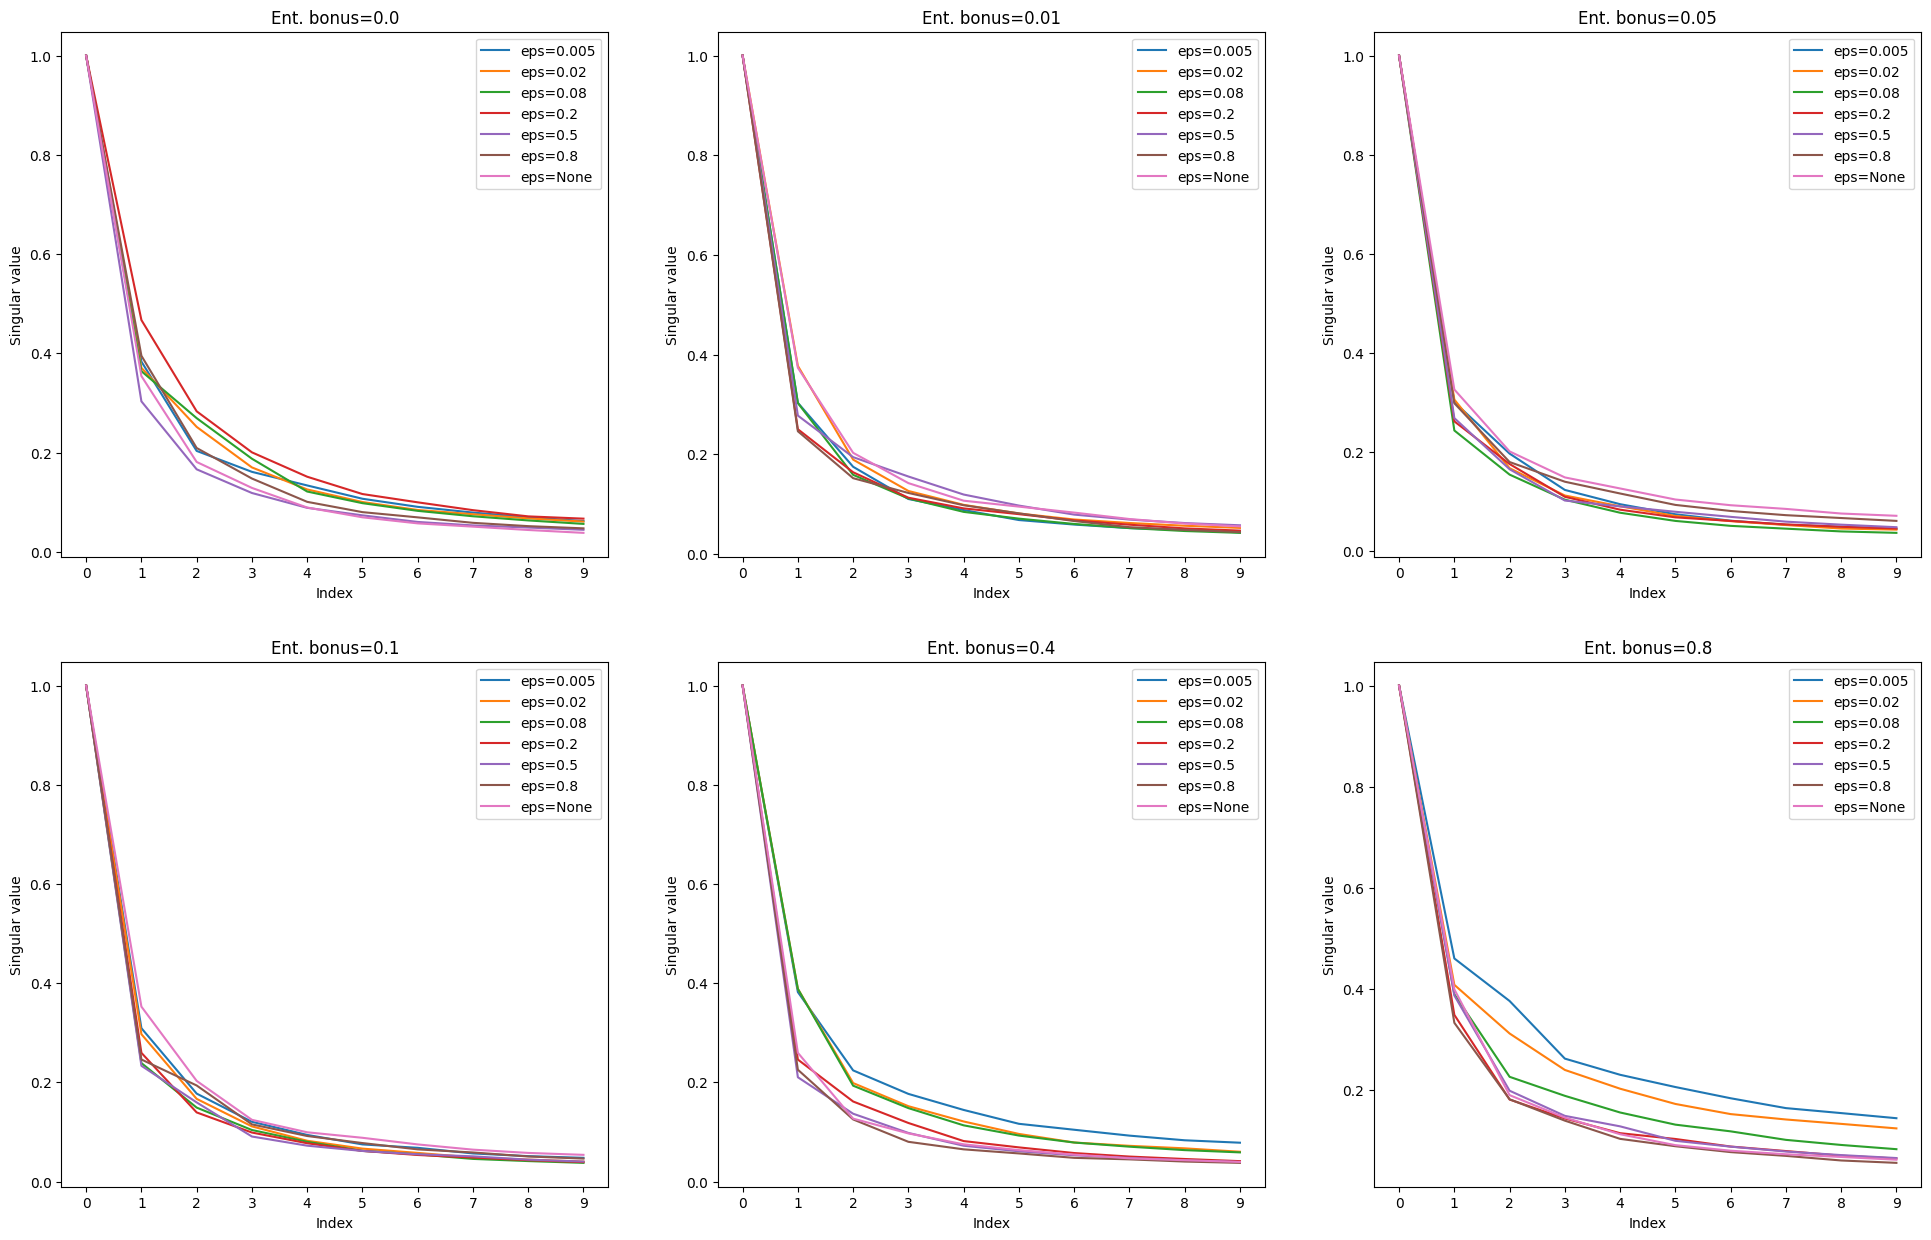

In [12]:
plot_svd("Breakout-MinAtar", ents, clips)

## 4. CartPole

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)
(500, 2)


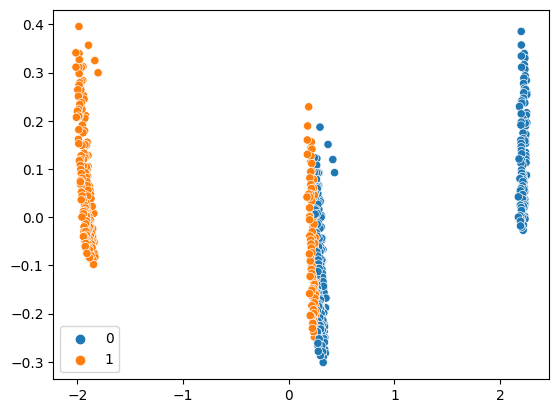

In [13]:
plot_features("CartPole-v1", ents, clips)

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)

Softmax accuracy


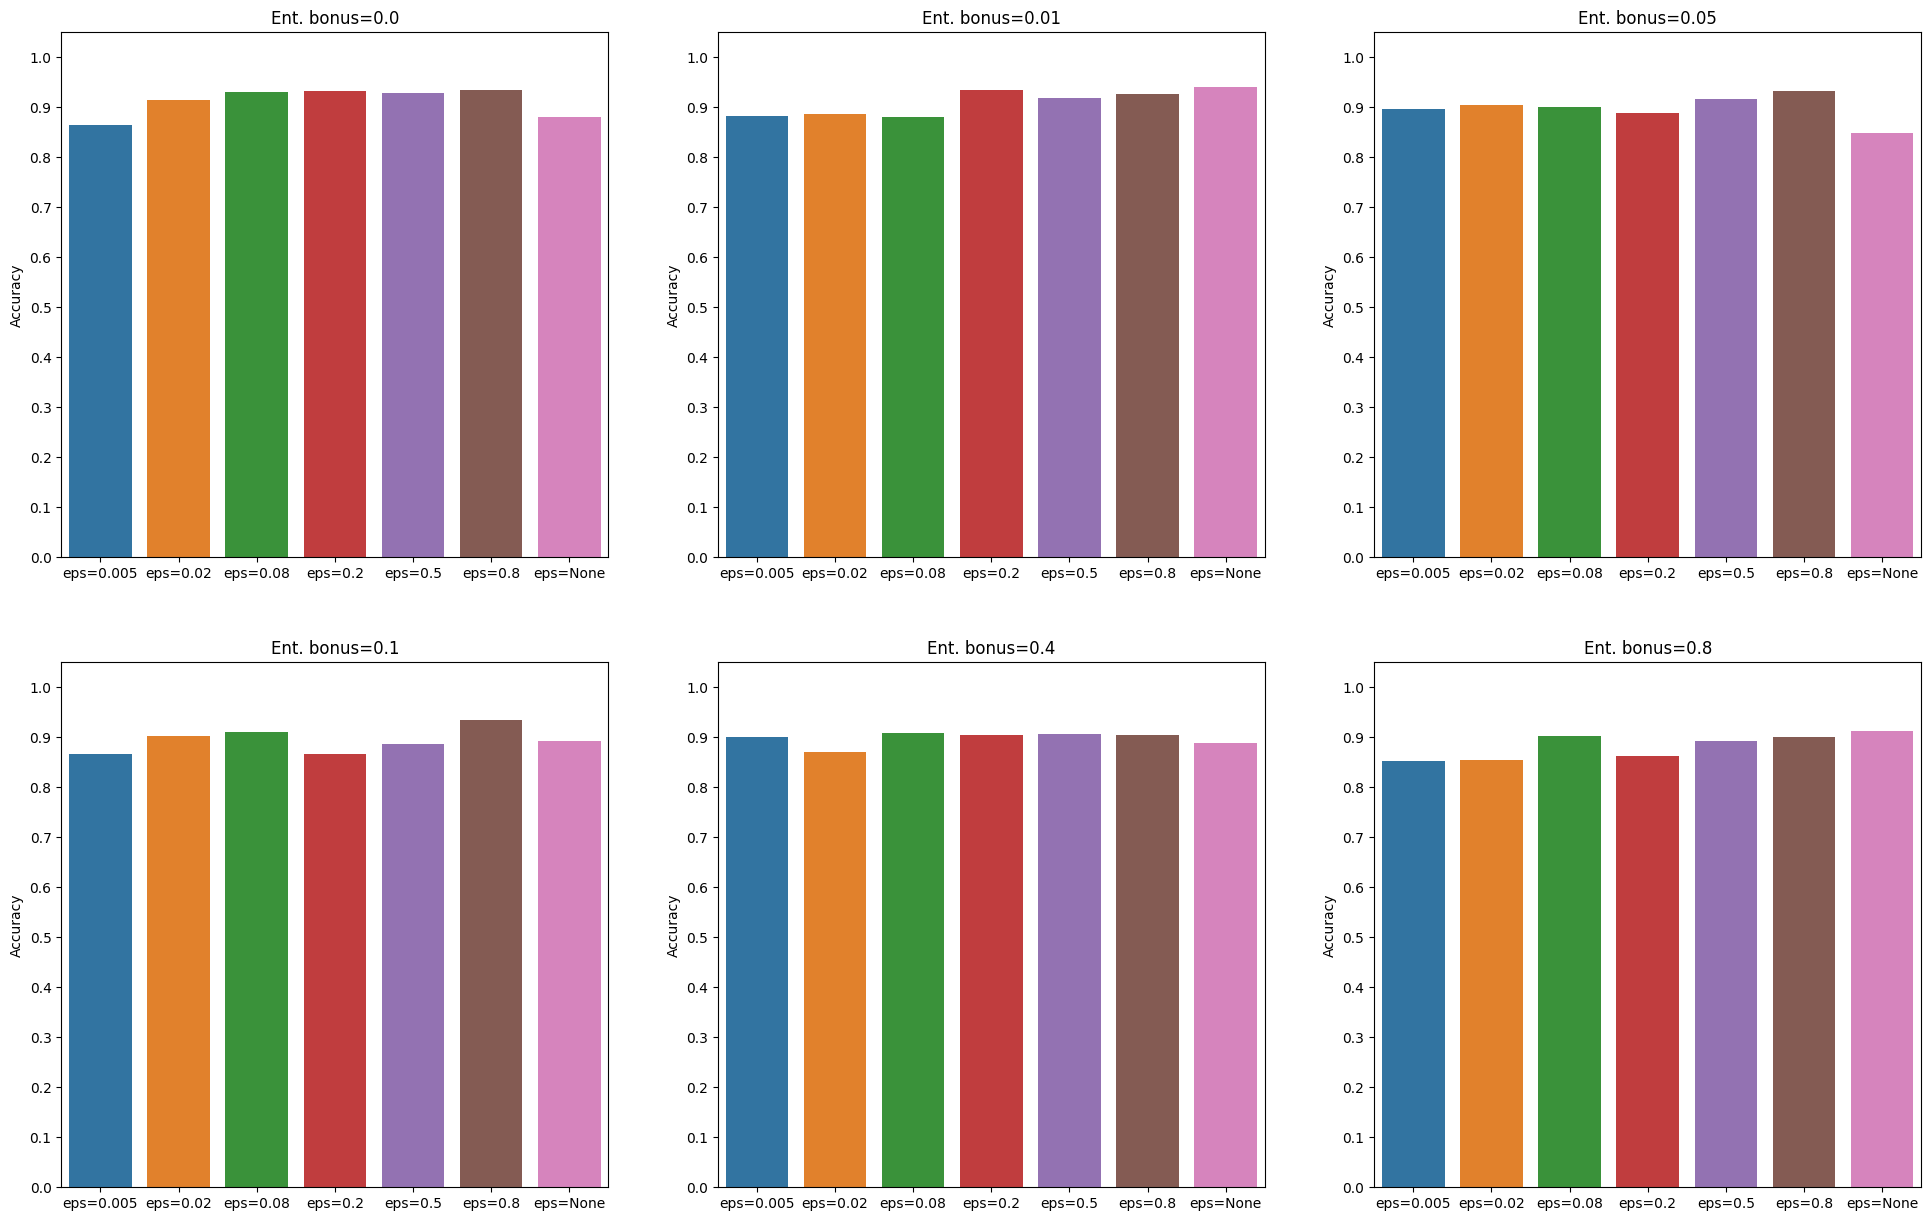

In [14]:
classify("CartPole-v1", ents, clips, algo="logreg")

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)
sF shape: (8, 6, 7, 64)
Max sF: 907.8521575073612

Singular values of feature matrix


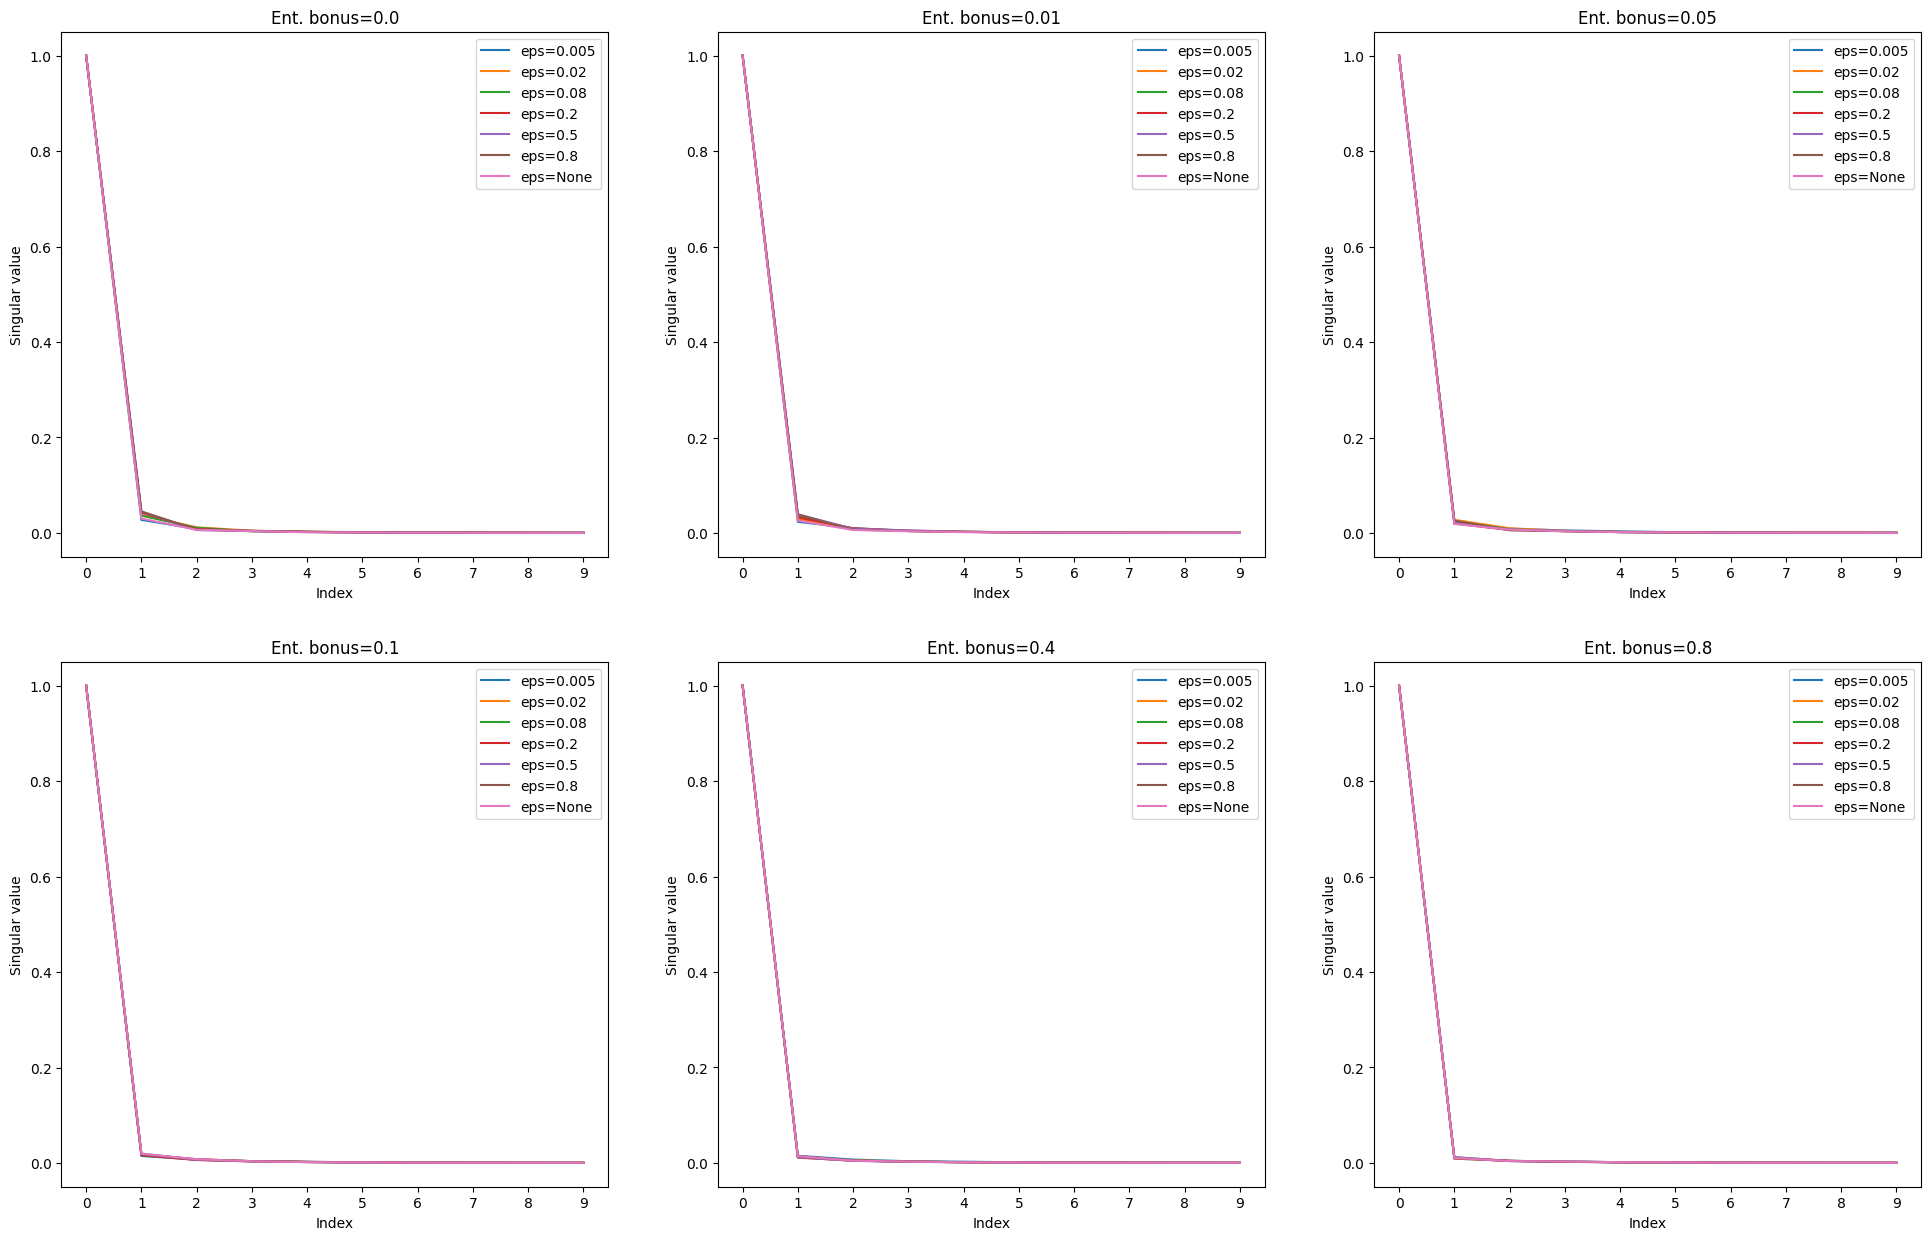

In [15]:
plot_svd("CartPole-v1", ents, clips)

## 5. Freeway

Actions shape: (8, 6, 7, 2500)
Features shape: (8, 6, 7, 2500, 256)
(2500, 2)


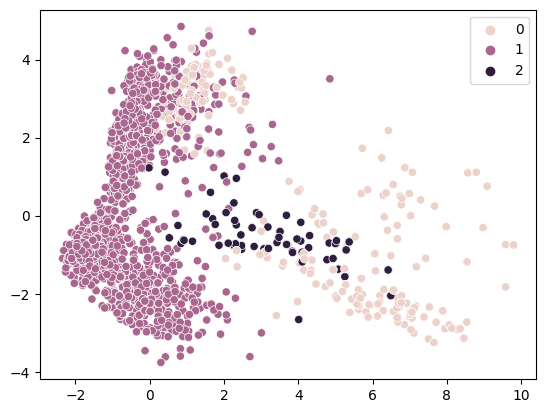

In [16]:
plot_features("Freeway-MinAtar", ents, clips)

Actions shape: (8, 6, 7, 2500)
Features shape: (8, 6, 7, 2500, 256)

Softmax accuracy


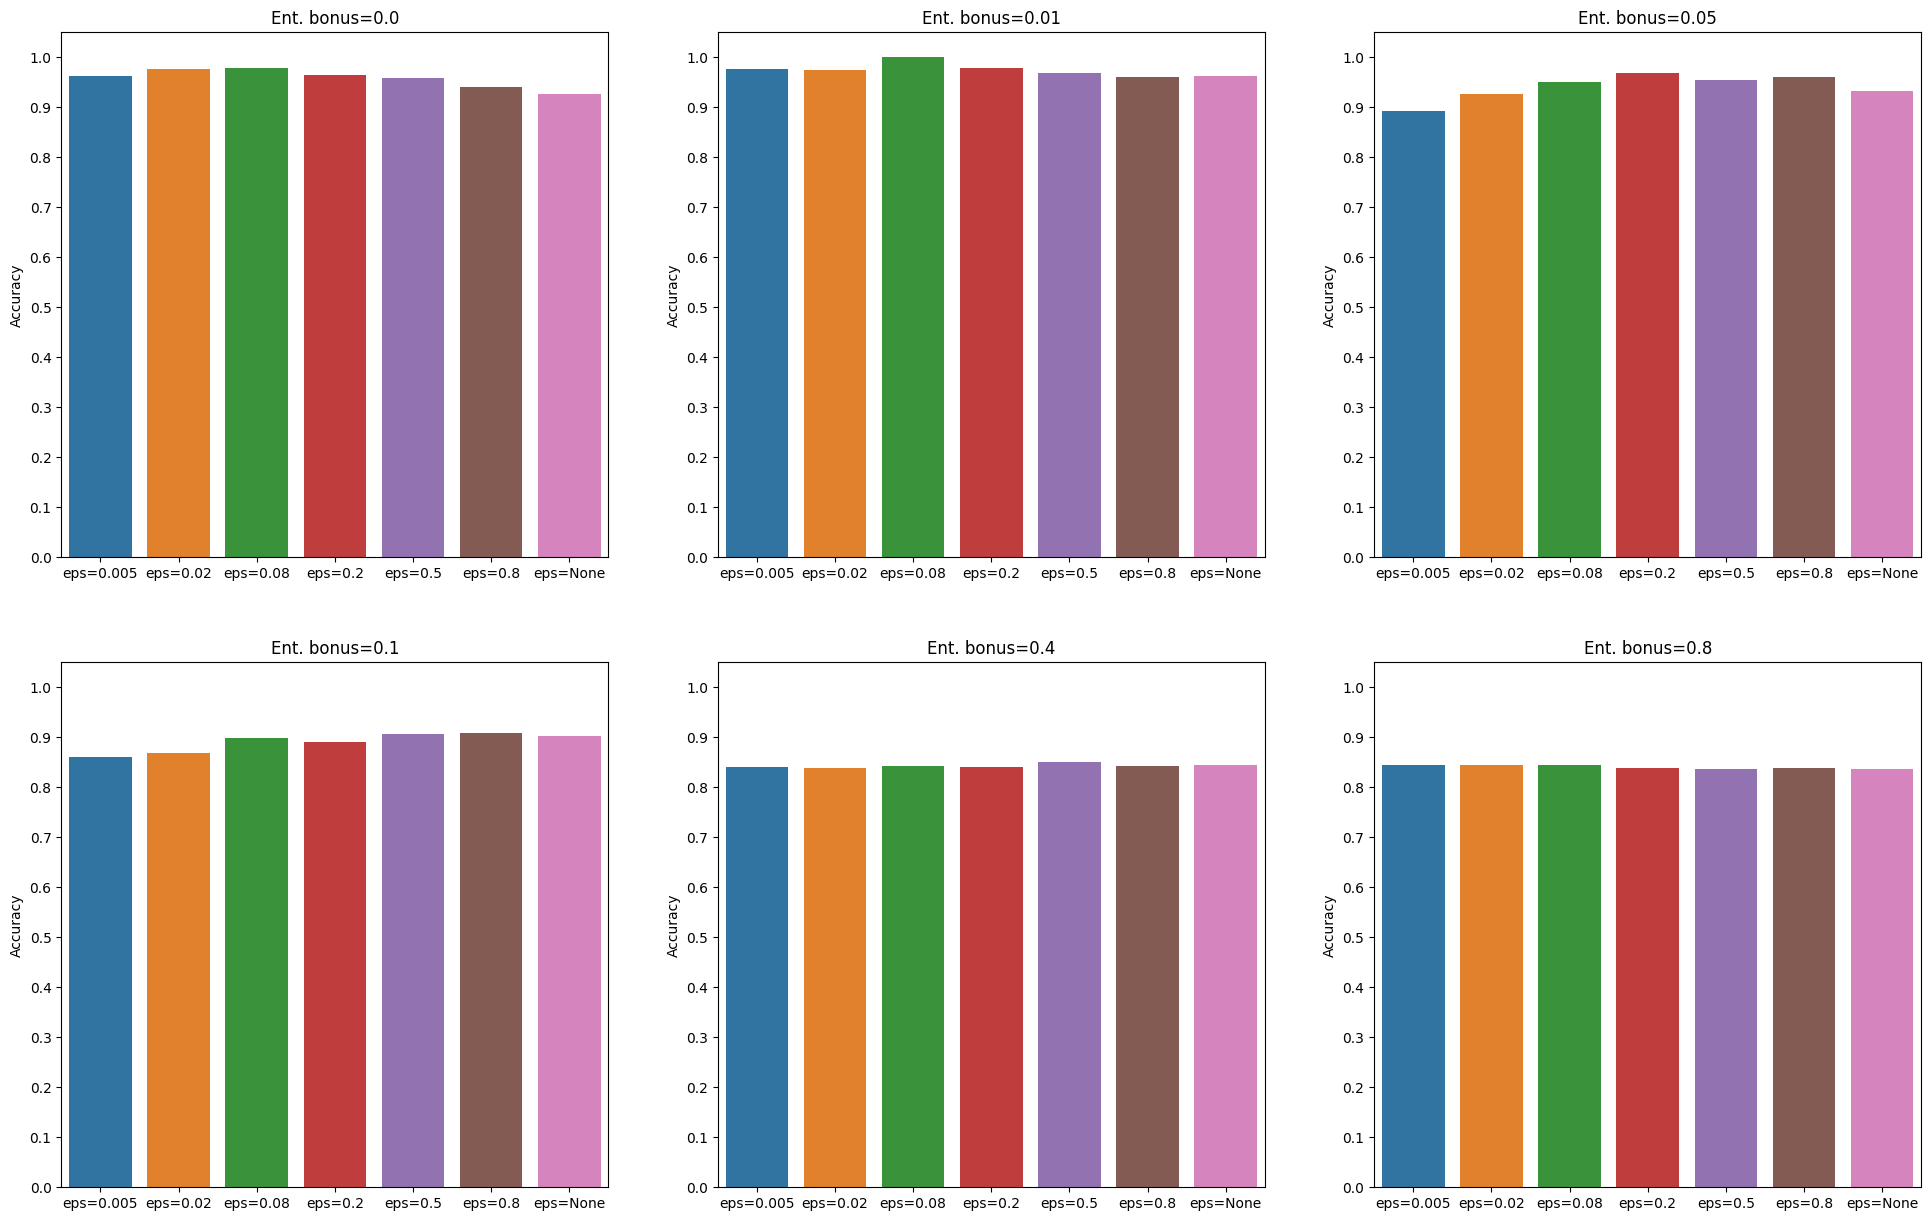

In [17]:
classify("Freeway-MinAtar", ents, clips, algo="logreg")

In [ ]:
plot_svd("Freeway-MinAtar", ents, clips)

Actions shape: (8, 6, 7, 2500)
Features shape: (8, 6, 7, 2500, 256)


## 6. MountainCar

Actions shape: (8, 6, 7, 200)
Features shape: (8, 6, 7, 200, 64)
(200, 2)


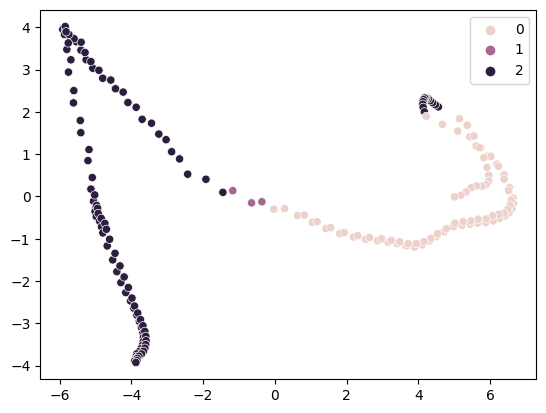

In [4]:
plot_features("MountainCar-v0", ents, clips)

Actions shape: (8, 6, 7, 200)
Features shape: (8, 6, 7, 200, 64)

Linear SVC accuracy


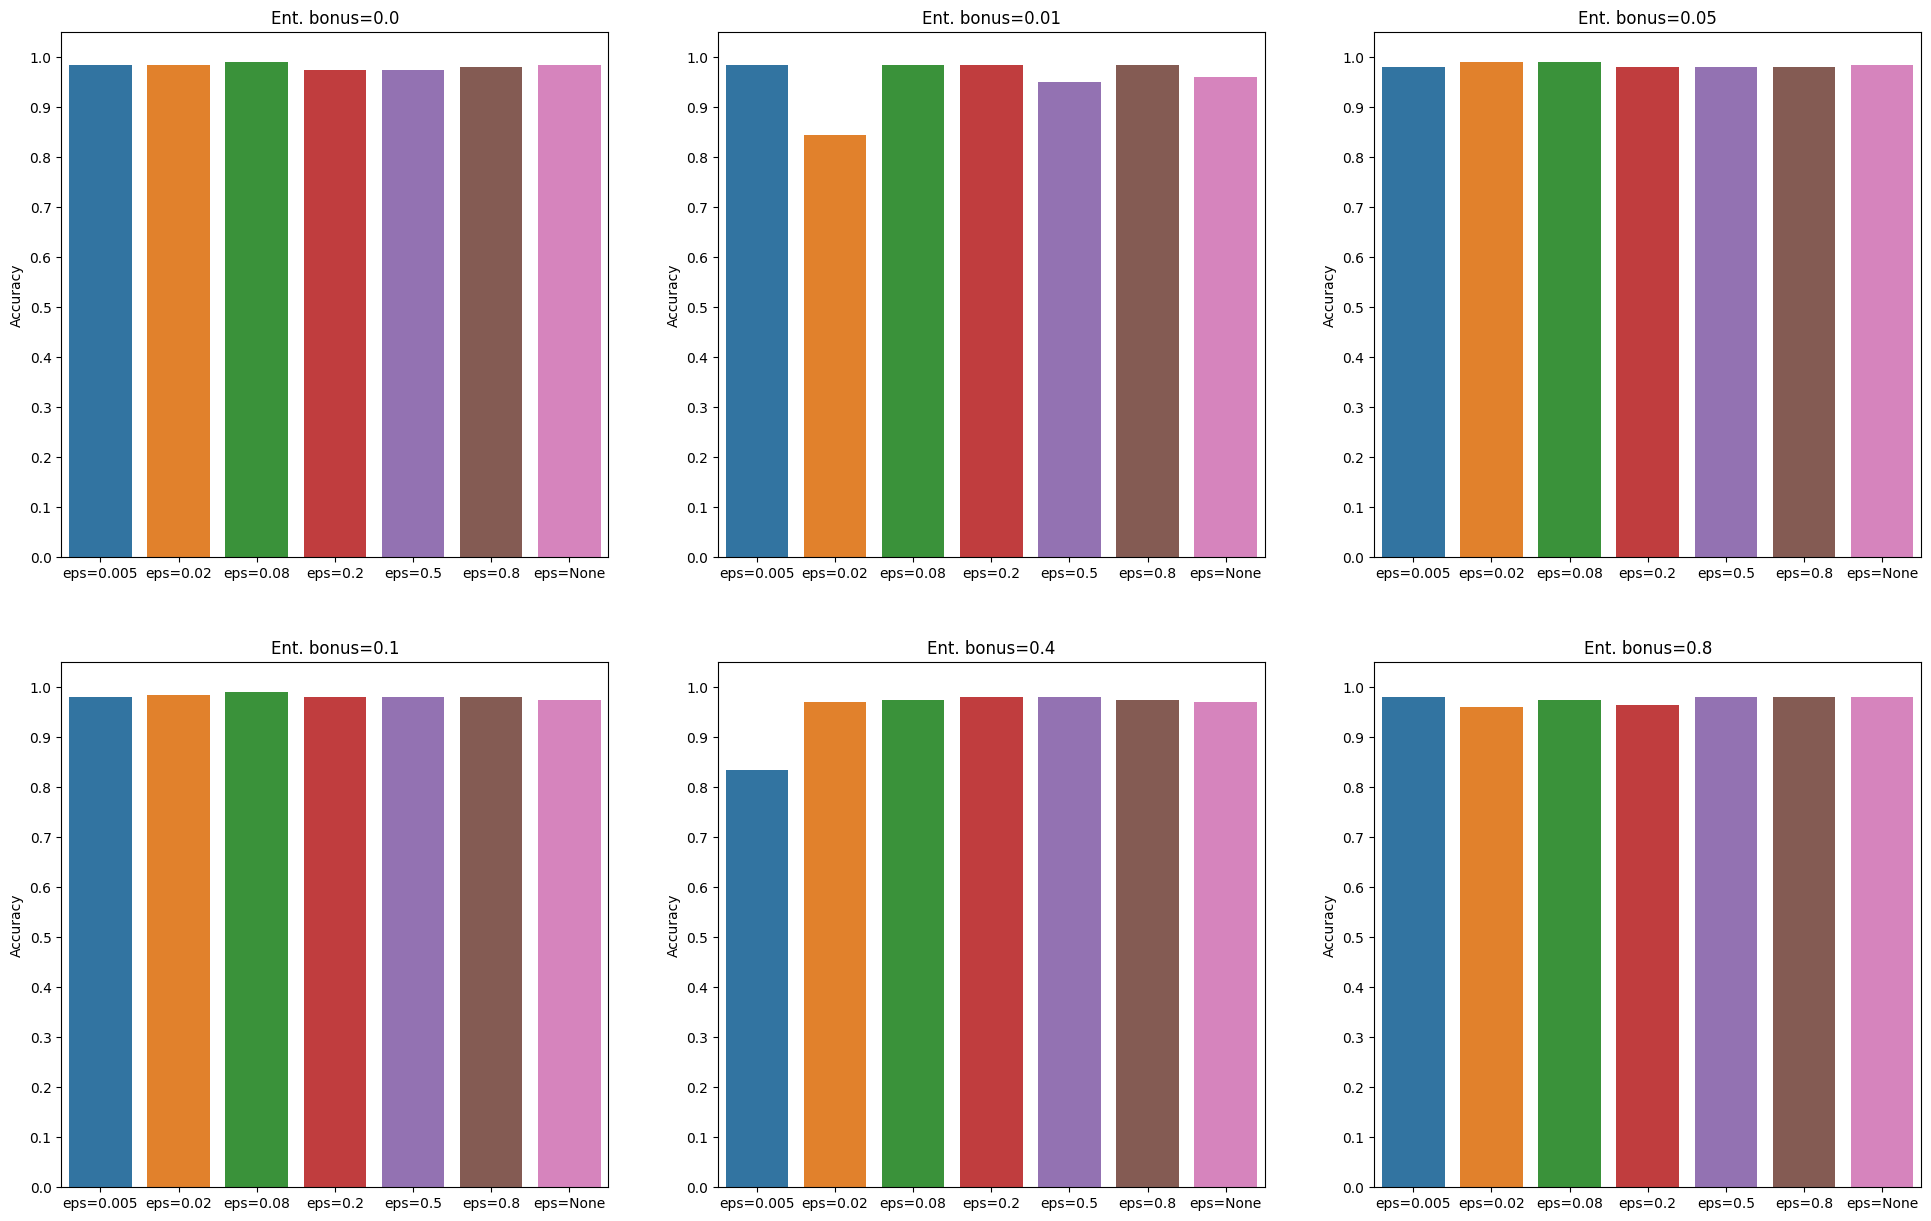

In [5]:
classify("MountainCar-v0", ents, clips, algo="svc")

Actions shape: (8, 6, 7, 200)
Features shape: (8, 6, 7, 200, 64)
sF shape: (8, 6, 7, 64)
Max sF: 552.181523114974

Singular values of feature matrix


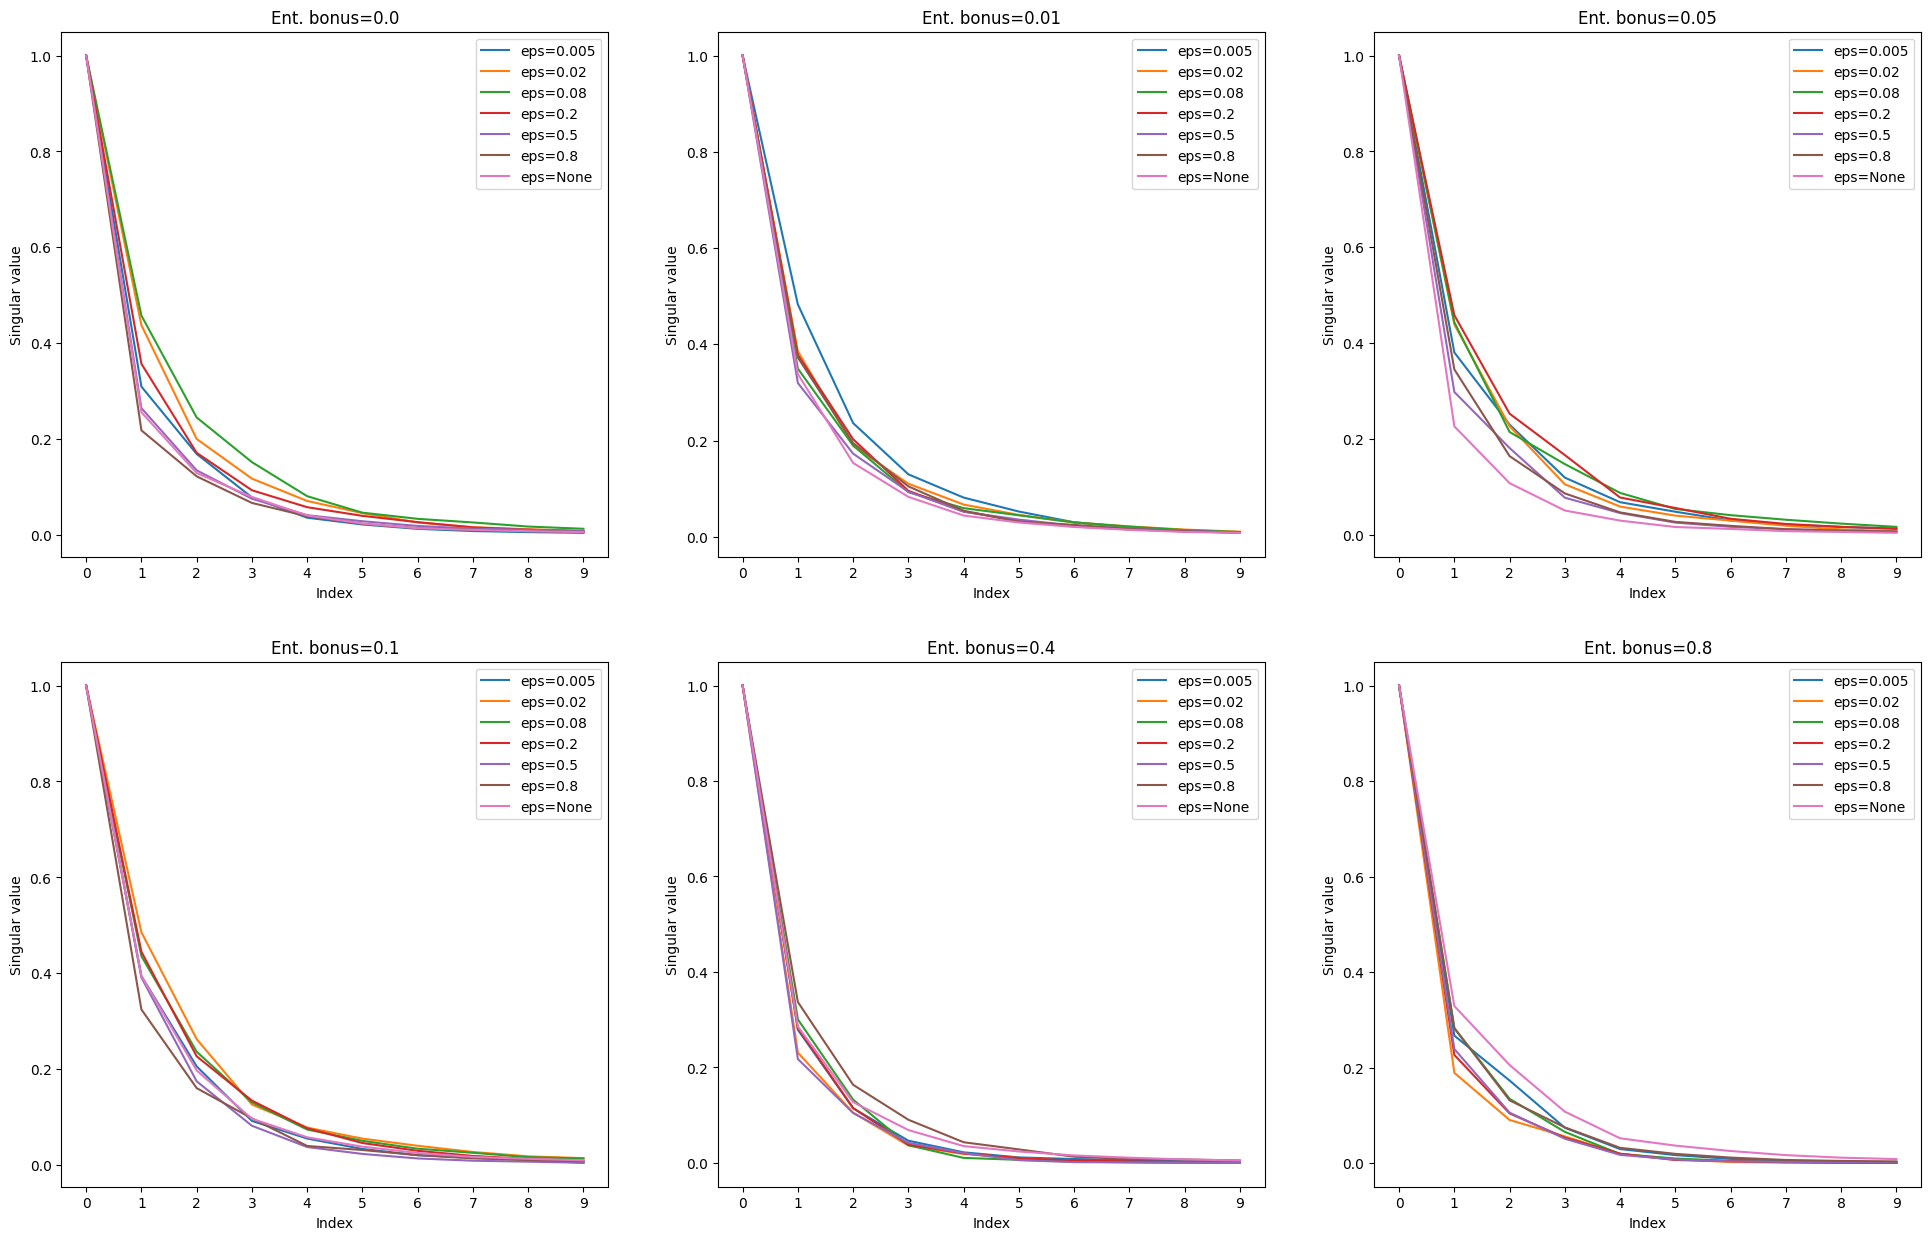

In [6]:
plot_svd("MountainCar-v0", ents, clips)

## 7. SpaceInvaders

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
(1000, 2)


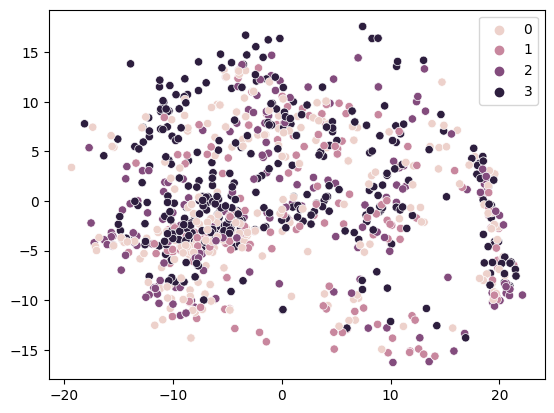

In [7]:
plot_features("SpaceInvaders-MinAtar", ents, clips)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)

Softmax accuracy


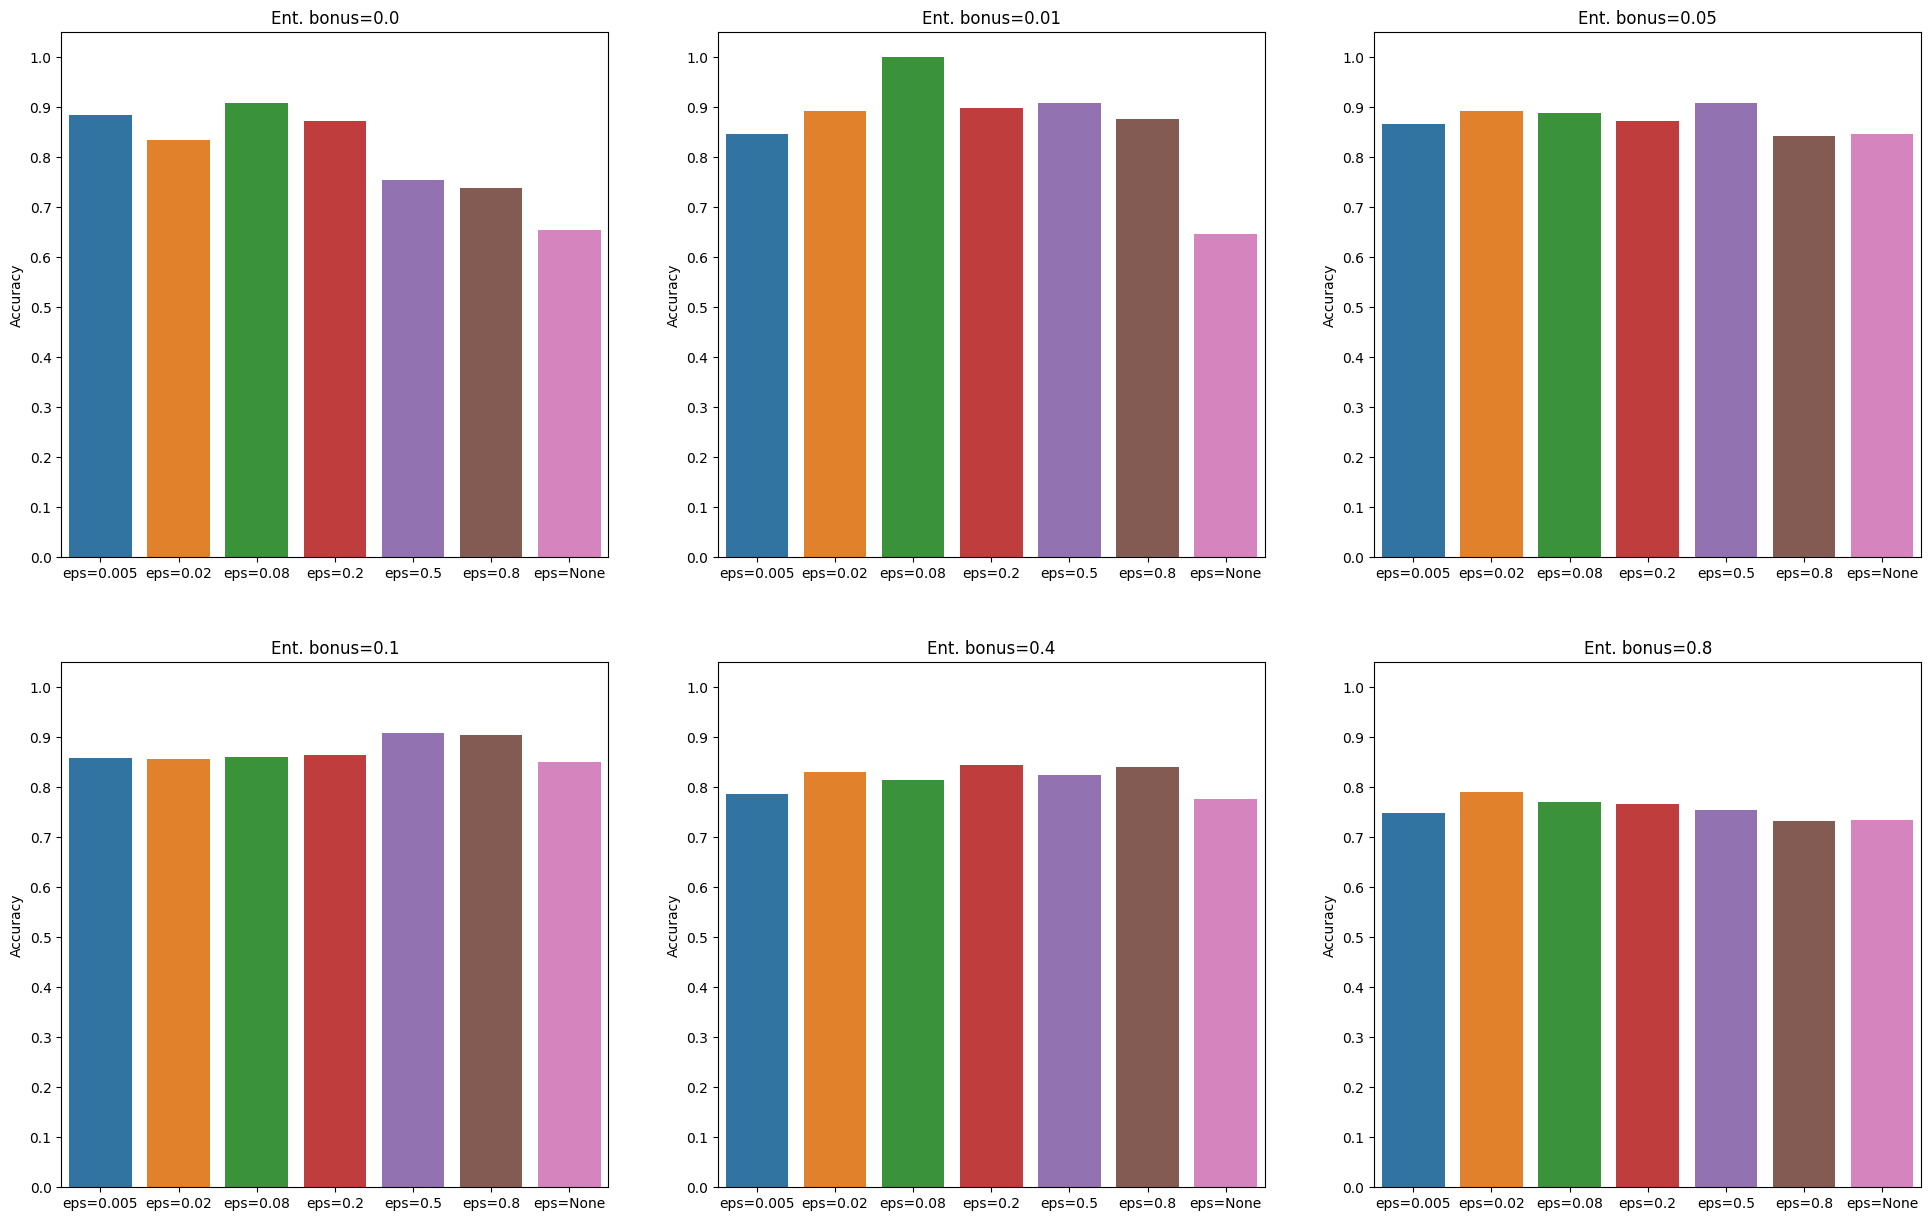

In [8]:
classify("SpaceInvaders-MinAtar", ents, clips, algo="logreg")

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
sF shape: (8, 6, 7, 256)
Max sF: 1801.6614

Singular values of feature matrix


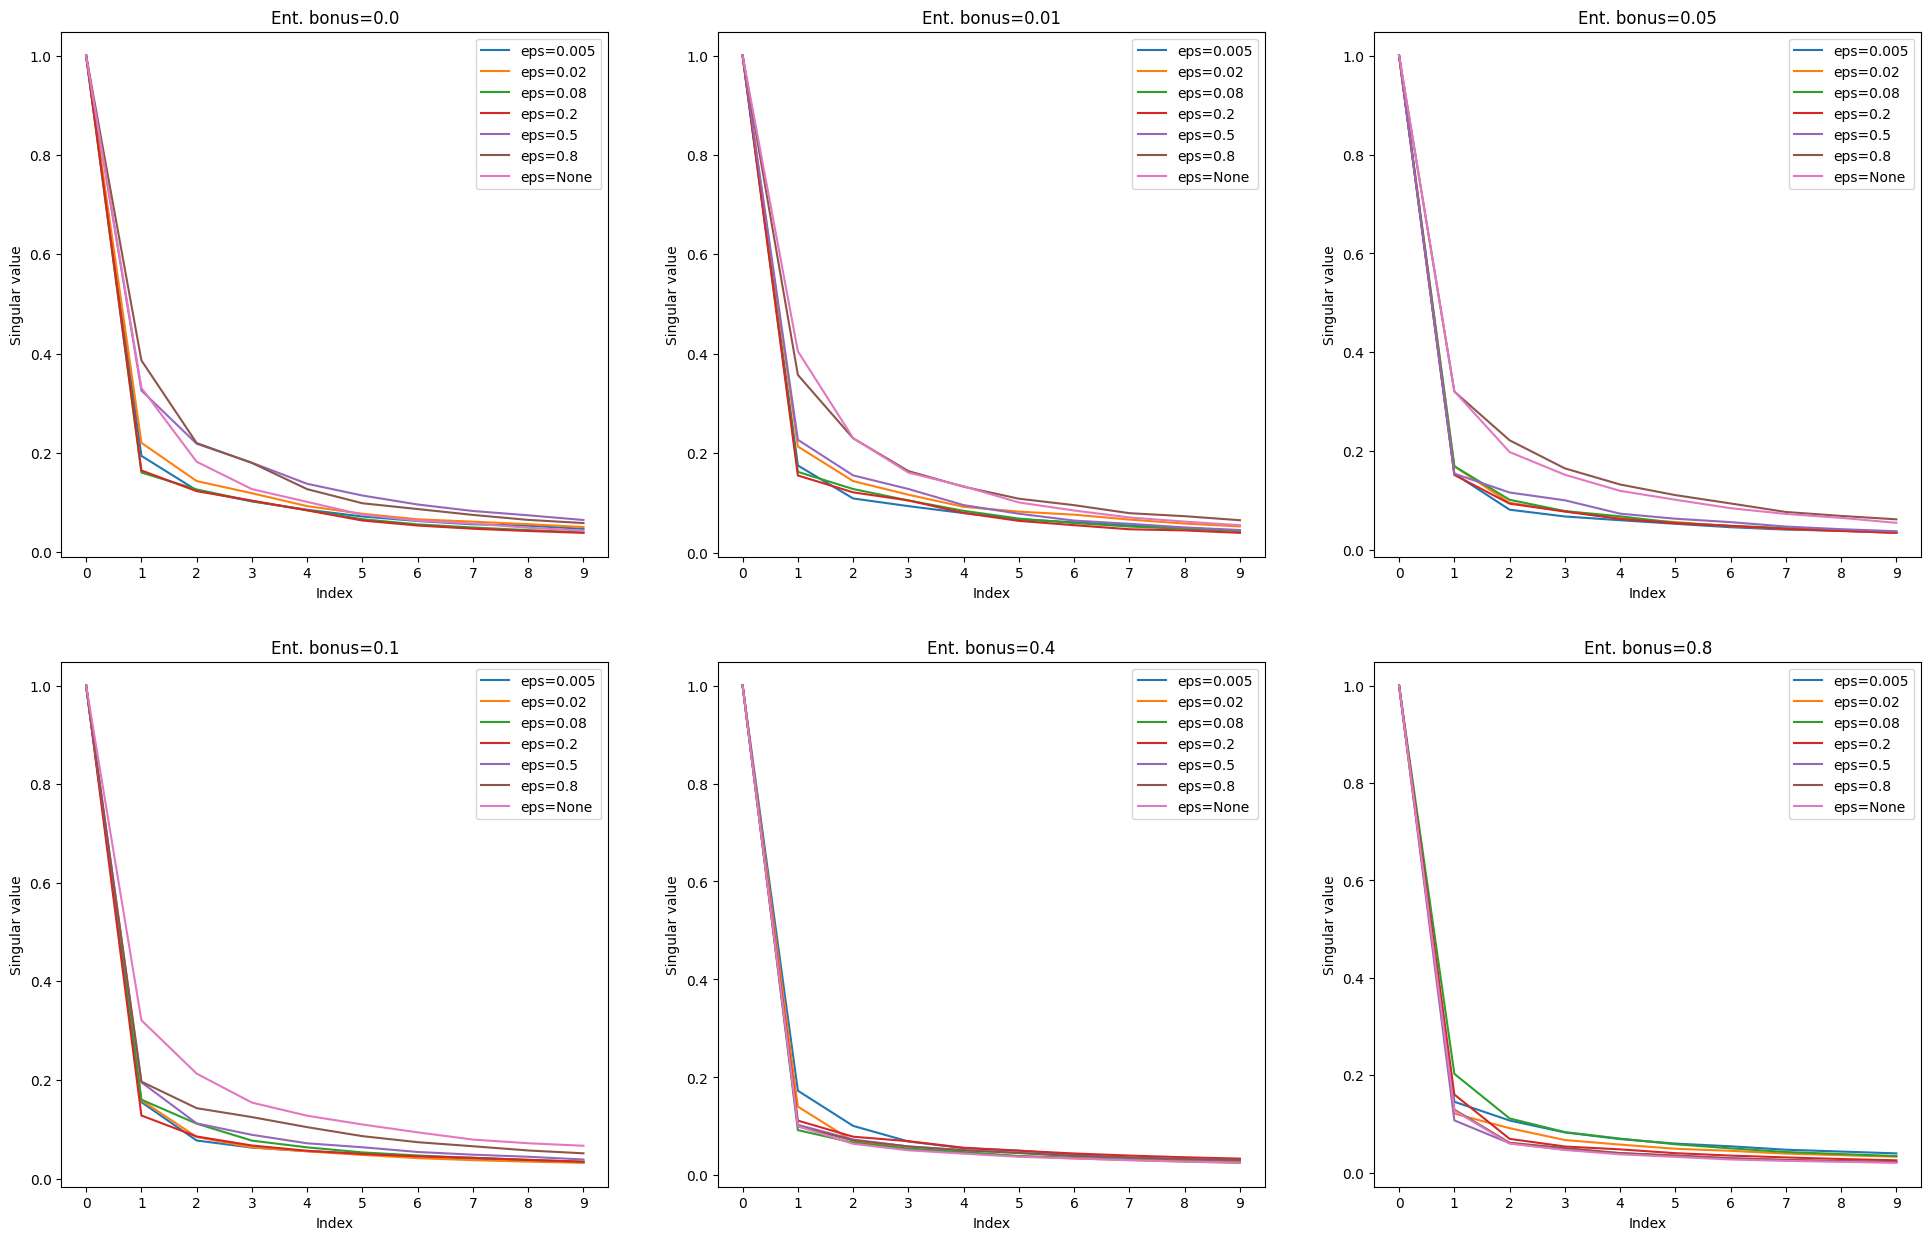

In [9]:
plot_svd("SpaceInvaders-MinAtar", ents, clips)